In [ ]:
!pip install umap-learn --user

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch import optim
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import entropy
import csv

from sklearn.manifold import TSNE
import umap

## Define models

In [ ]:
class GeneratedCNN(nn.Module):
  def __init__(self,custom_filters1=None, custom_filters2=None,):
    super().__init__()
    # First convolutional layer (in_channels, out_channels, kernel_size) , out_channels = number of filters
    # 3 input channels, 6 output channels, 5x5 kernel size
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)

    if custom_filters1 is not None:
        assert custom_filters1.shape == self.conv1.weight.shape, \
            f"custom_filters1 must have shape {self.conv1.weight.shape}"
        self.conv1.weight = nn.Parameter(custom_filters1)
    else:
        nn.init.kaiming_normal_(self.conv1.weight)  # Default initialization
    self.conv1.bias = nn.Parameter(torch.zeros(6))  # Set bias to 0

        # Assign custom filters to conv2 if provided
    if custom_filters2 is not None:
        assert custom_filters2.shape == self.conv2.weight.shape, \
            f"custom_filters2 must have shape {self.conv2.weight.shape}"
        self.conv2.weight = nn.Parameter(custom_filters2)
    else:
        nn.init.kaiming_normal_(self.conv2.weight)  # Default initialization
    self.conv2.bias = nn.Parameter(torch.zeros(16))  # Set bias to 0

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x))) #apply conv. then apply pooling
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)  # Flatten to (batch_size, features)
    return x

class Generator_0(nn.Module):
    def __init__(self):
        super(Generator_0, self).__init__()
        self.main = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Generator_2(nn.Module):
    def __init__(self):
        super(Generator_2, self).__init__()
        self.main = nn.Sequential(
            nn.Conv3d(6, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 6, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

## Define device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

## Load models

In [160]:
G_A2B_0 = Generator_0().to(device)
G_A2B_0.load_state_dict(torch.load('./generator_A2B.pth',weights_only = True))

G_B2A_0 = Generator_0().to(device)
G_B2A_0.load_state_dict(torch.load('./generator_B2A.pth',weights_only = True))

G_A2B_2 = Generator_2().to(device)
G_A2B_2.load_state_dict(torch.load('./2_generator_A2B.pth',weights_only = True))

G_B2A_2 = Generator_2().to(device)
G_B2A_2.load_state_dict(torch.load('./2_generator_B2A.pth',weights_only = True))



<All keys matched successfully>

## Generate Filters

In [1047]:
model = 226
real_A_2 = torch.load(f'./black_layers_permuted/2/2_{model:04}.pth', weights_only=True).to(device)
real_A_0 = torch.load(f'./black_layers_permuted/0/0_{model:04}.pth', weights_only=True).to(device)
real_B_2 = torch.load(f'./cat_layers_permuted/2/2_{model:04}.pth', weights_only=True).to(device)
real_B_0 = torch.load(f'./cat_layers_permuted/0/0_{model:04}.pth', weights_only=True).to(device)


# Assuming G_A and G_B are your trained generators
G_A2B_0.to(device).eval()
G_B2A_0.to(device).eval()
G_A2B_2.to(device).eval()
G_B2A_2.to(device).eval()

# Generate layer0 fake images (domain A -> B and B -> A)
fake_B_0 = G_A2B_0(real_A_0).permute(1, 0, 2, 3)
fake_A_0 = G_B2A_0(real_B_0).permute(1, 0, 2, 3)

# Generate layer2 fake images (domain A -> B and B -> A)
fake_B_2 = G_A2B_2(real_A_2).permute(1, 0, 2, 3)
fake_A_2 = G_B2A_2(real_B_2).permute(1, 0, 2, 3)

## Initialize CNN

In [1048]:
cnn_model_A = GeneratedCNN(fake_A_0, fake_A_2)
cnn_model_B = GeneratedCNN(fake_B_0, fake_B_2)

## Extract feature

In [1049]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
testset = ImageFolder(root='./GeneratedCNN_test', transform=transform)
# Assign all images to the same dummy class (e.g., 0)
testset.targets = [0] * len(testset)

testloader = torch.utils.data.DataLoader(testset, batch_size = 1)

cnn_model_A.to(device).eval()
cnn_model_B.to(device).eval()

features_A = []
print("Model A:")
for images, _ in testloader:  # The second element is a dummy label (always 0)
    images = images.to(device)
    with torch.no_grad():  # Disable gradient computation
        features = cnn_model_A(images)  # Extract features or predictions
        features_A.append(features.cpu().numpy())

features_A = np.vstack([feat[0] for feat in features_A])
print(np.array(features_A).shape)
#print(features_A[0])


features_B = []
print("\n\nModel B:")
for images, _ in testloader:  # The second element is a dummy label (always 0)
    images = images.to(device)
    with torch.no_grad():  # Disable gradient computation
        features = cnn_model_B(images)  # Extract features or predictions
        features_B.append(features.cpu().numpy())

features_B = np.vstack([feat[0] for feat in features_B])
print(np.array(features_B).shape)

Model A:
(89, 400)


Model B:
(89, 400)


# Feature Distance

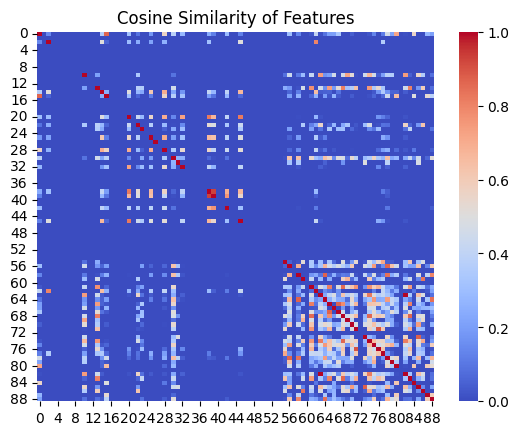

In [1050]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

# Alternatively, compute cosine similarity
similarity = cosine_similarity(features_A)

# Visualize the similarity or distance matrix
import seaborn as sns
sns.heatmap(similarity, cmap='coolwarm')
plt.title("Cosine Similarity of Features")
plt.show()


# Visualize Feature Similarity with Dimensionality Reduction

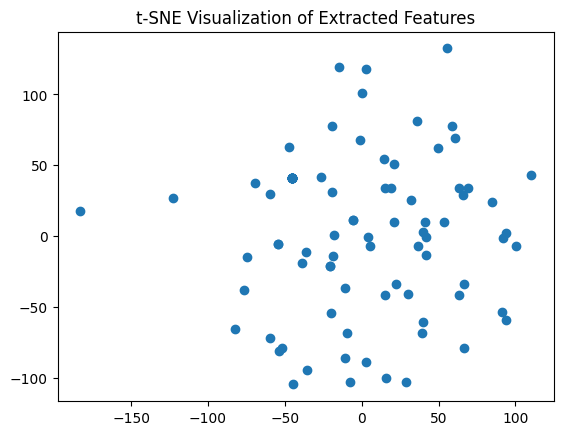

In [1051]:
# Apply t-SNE
# n_components is for 2d or 3d
# mdel 4 feature B, random 7 perplex 32
tsne = TSNE(n_components=3, random_state=7, perplexity=8)
reduced_features = tsne.fit_transform(features_A)

# Visualize
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])  # Assign colors based on image type
plt.title("t-SNE Visualization of Extracted Features")
plt.show()

## UMAP

C:\Users\adi-pc\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


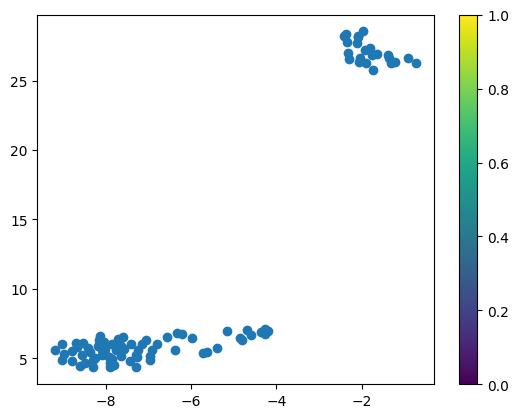

In [1052]:
# Create a UMAP reducer
reducer = umap.UMAP(n_components=2, random_state=47)

# Fit and transform the data
embedding = reducer.fit_transform(features_A)
#3embedding = reducer.fit_transform(features_B)

# Plot the results
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.colorbar()
plt.show()

## Kmeans

Cluster labels: [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1
 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1]


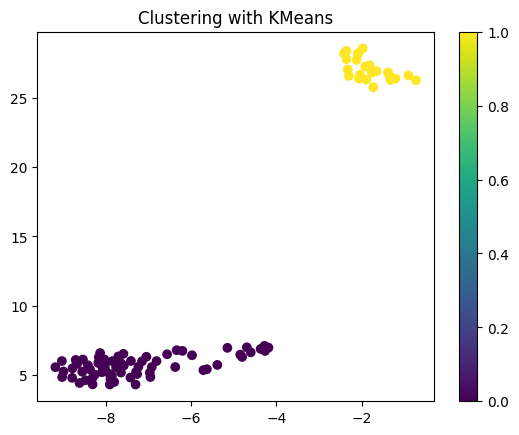

In [1053]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
#for model 3, use random state 3
# model 4, featureB, random state 1
# model 1234, feature A, random state 1
kmeans = KMeans(n_clusters=2, random_state=3)
#cluster_labels = kmeans.fit_predict(features_A)
#cluster_labels = kmeans.fit_predict(reduced_features)
k_means_cluster_labels = kmeans.fit_predict(embedding)

# Check clustering results
print("Cluster labels:", k_means_cluster_labels)

# Visualize cluster results
#plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels)
plt.scatter(embedding[:, 0], embedding[:, 1], c=k_means_cluster_labels)
plt.colorbar()
plt.title("Clustering with KMeans")
plt.show()


# One class SVM

In [1045]:
from sklearn.svm import OneClassSVM
# Need to try
# Train on "our-type" features (using all features as if they are "normal" here)
oc_svm = OneClassSVM(kernel='rbf', nu=0.1)
oc_svm.fit(embedding[-34:])

# Predict on the same features (inliers as 1, outliers as -1)
ocsvm_predictions = oc_svm.predict(embedding)
print(ocsvm_predictions)


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1]


# DBSCAN

Cluster labels: [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1
 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1]


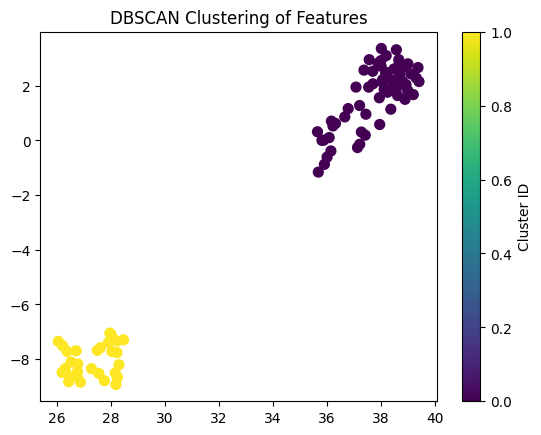

In [1046]:
from sklearn.cluster import DBSCAN
# Hyperparameters for DBSCAN
#BEST RESULTS FOUND IN 2-2.5 RANGE
#model 4 feature B, e=5.4, m=4 or 5.7,5
eps = 1  # Maximum distance between two samples to be considered neighbors
min_samples = 5 # Minimum number of samples in a neighborhood for a core point

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')

# UMap results
dbscan_cluster_labels = dbscan.fit_predict(embedding)
print("Cluster labels:", dbscan_cluster_labels)

# Plot clustering results
#plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.scatter(embedding[:, 0], embedding[:, 1], c=dbscan_cluster_labels, cmap='viridis', s=50)
plt.colorbar(label="Cluster ID")
plt.title("DBSCAN Clustering of Features")
plt.show()


## Evatuation Metrics

In [1020]:
def confusion_matrix(printval:bool,array):
  tpcounterarr=Counter(array[-34:])
  label = tpcounterarr.most_common()[0][0]
  tpcounter = tpcounterarr.most_common()[0][1]
  fpcounter=len(array[-34:])-tpcounter
  notlabel=(np.array(array[:55])!=label)
  tncounter=np.sum(notlabel)
  fncounter=len(array[:55])-tncounter
  # Print the results
  if printval:
    print("TP : ",tpcounter)
    print("TN : ",tncounter)
    print("FP : ",fpcounter)
    print("FN : ",fncounter)

  return [tpcounter,tncounter,fpcounter,fncounter]

def calculate_entropy(array):
    """Calculates the entropy of an array."""
    _, counts = np.unique(array, return_counts=True)
    probabilities = counts / len(array)
    return entropy(probabilities, base=2)

def calculate_purity(array):
    """Calculates the purity of an array."""
    _, counts = np.unique(array, return_counts=True)
    return max(counts) / len(array)

def evaluate_metrics(array):
  tp,tn,fp,fn = confusion_matrix(False,array)
  accuracy = (tp+tn) / 89
  precision = tp/(tp+fp)
  recall=tp/(tp+fn)
  entropy=(55*(calculate_entropy(array[:55])) + 34 *(calculate_entropy(array[-34:])))/89
  purity=(55*(calculate_purity(array[:55])) + 34 *(calculate_purity(array[-34:])))/89

  return accuracy,precision,recall,entropy,purity


print("k",evaluate_metrics(k_means_cluster_labels))
print("o",evaluate_metrics(ocsvm_predictions))
print("d",evaluate_metrics(dbscan_cluster_labels))

k (np.float64(0.8764044943820225), 0.8529411764705882, np.float64(0.8285714285714286), np.float64(0.5373806083961716), np.float64(0.8764044943820225))
o (np.float64(0.7528089887640449), 0.9117647058823529, np.float64(0.62), np.float64(0.7391643248860658), np.float64(0.7528089887640449))
d (np.float64(0.8764044943820225), 0.7941176470588235, np.float64(0.8709677419354839), np.float64(1.4641466854673388), np.float64(0.5617977528089888))


## CAlcualte metrics for all models

In [473]:
good_A = [21,214,226,229,253,307,959,1205,1234,1278,1304,1311,1314,1330,1337,1392,1470,1486,1507,1567]

good_B = [229,282,311,478,805,1215,1291,1540]

results = []

for i in good_A:
    model = i
    real_A_2 = torch.load(f'./black_layers_permuted/2/2_{model:04}.pth', weights_only=True).to(device)
    real_A_0 = torch.load(f'./black_layers_permuted/0/0_{model:04}.pth', weights_only=True).to(device)
    real_B_2 = torch.load(f'./cat_layers_permuted/2/2_{model:04}.pth', weights_only=True).to(device)
    real_B_0 = torch.load(f'./cat_layers_permuted/0/0_{model:04}.pth', weights_only=True).to(device)


    # Assuming G_A and G_B are your trained generators
    G_A2B_0.to(device).eval()
    G_B2A_0.to(device).eval()
    G_A2B_2.to(device).eval()
    G_B2A_2.to(device).eval()

    # Generate layer0 fake images (domain A -> B and B -> A)
    fake_B_0 = G_A2B_0(real_A_0).permute(1, 0, 2, 3)
    fake_A_0 = G_B2A_0(real_B_0).permute(1, 0, 2, 3)

    # Generate layer2 fake images (domain A -> B and B -> A)
    fake_B_2 = G_A2B_2(real_A_2).permute(1, 0, 2, 3)
    fake_A_2 = G_B2A_2(real_B_2).permute(1, 0, 2, 3)

    # Initialise models
    cnn_model_A = GeneratedCNN(fake_A_0, fake_A_2)
    cnn_model_B = GeneratedCNN(fake_B_0, fake_B_2)

    # Extract features
    cnn_model_A.to(device).eval()
    cnn_model_B.to(device).eval()

    features_A = []
    for images, _ in testloader:  # The second element is a dummy label (always 0)
        images = images.to(device)
        with torch.no_grad():  # Disable gradient computation
            features = cnn_model_A(images)  # Extract features or predictions
            features_A.append(features.cpu().numpy())

    features_A = np.vstack([feat[0] for feat in features_A])
    
    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=7)
    embedding = reducer.fit_transform(features_A)
    # Kmeans
    kmeans = KMeans(n_clusters=2, random_state=1)
    k_means_cluster_labels = kmeans.fit_predict(embedding)
    # OC_SVM
    oc_svm = OneClassSVM(kernel='rbf', nu=0.1)
    oc_svm.fit(embedding[-34:])
    ocsvm_predictions = oc_svm.predict(embedding)
    # DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    dbscan_cluster_labels = dbscan.fit_predict(embedding)

    results.append([model,evaluate_metrics(k_means_cluster_labels),evaluate_metrics(ocsvm_predictions),evaluate_metrics(dbscan_cluster_labels)])


csv_file_path = "Evaluation_metrics_A.csv"
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Model', 'kmeans', 'ocsvm', 'dbscan'])
    writer.writerows(results)

print(f"CSV file saved at: {csv_file_path}")

C:\Users\adi-pc\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\adi-pc\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\adi-pc\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\adi-pc\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

## PLot cosine similarity for all models

In [ ]:
for i in range(1749):
    model = i
    real_A_2 = torch.load(f'./black_layers_permuted/2/2_{model:04}.pth', weights_only=True).to(device)
    real_A_0 = torch.load(f'./black_layers_permuted/0/0_{model:04}.pth', weights_only=True).to(device)
    real_B_2 = torch.load(f'./cat_layers_permuted/2/2_{model:04}.pth', weights_only=True).to(device)
    real_B_0 = torch.load(f'./cat_layers_permuted/0/0_{model:04}.pth', weights_only=True).to(device)


    # Assuming G_A and G_B are your trained generators
    G_A2B_0.to(device).eval()
    G_B2A_0.to(device).eval()
    G_A2B_2.to(device).eval()
    G_B2A_2.to(device).eval()

    # Generate layer0 fake images (domain A -> B and B -> A)
    fake_B_0 = G_A2B_0(real_A_0).permute(1, 0, 2, 3)
    fake_A_0 = G_B2A_0(real_B_0).permute(1, 0, 2, 3)

    # Generate layer2 fake images (domain A -> B and B -> A)
    fake_B_2 = G_A2B_2(real_A_2).permute(1, 0, 2, 3)
    fake_A_2 = G_B2A_2(real_B_2).permute(1, 0, 2, 3)

    # Initialise models
    cnn_model_A = GeneratedCNN(fake_A_0, fake_A_2)
    cnn_model_B = GeneratedCNN(fake_B_0, fake_B_2)

    # Extract features
    cnn_model_A.to(device).eval()
    cnn_model_B.to(device).eval()

    features_A = []
    for images, _ in testloader:  # The second element is a dummy label (always 0)
        images = images.to(device)
        with torch.no_grad():  # Disable gradient computation
            features = cnn_model_A(images)  # Extract features or predictions
            features_A.append(features.cpu().numpy())

    features_A = np.vstack([feat[0] for feat in features_A])

    features_B = []
    for images, _ in testloader:  # The second element is a dummy label (always 0)
        images = images.to(device)
        with torch.no_grad():  # Disable gradient computation
            features = cnn_model_B(images)  # Extract features or predictions
            features_B.append(features.cpu().numpy())

    features_B = np.vstack([feat[0] for feat in features_B])

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(5,2))

    similarity = cosine_similarity(features_A)
    sns.heatmap(similarity, cmap='coolwarm', ax=ax1)
    plt.title(f"Cosine Similarity of Model {model} Features A")


    similarity = cosine_similarity(features_B)
    sns.heatmap(similarity, cmap='coolwarm', ax=ax2)
    plt.title(f"Cosine Similarity of Model {model} Features B")


    fig.tight_layout()
    plt.show()
    plt.close()
    plt.close()


## Visualise

In [988]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))
        grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))


torch.Size([6, 3, 5, 5])
torch.Size([16, 6, 5, 5])
torch.Size([6, 3, 5, 5])
torch.Size([16, 6, 5, 5])


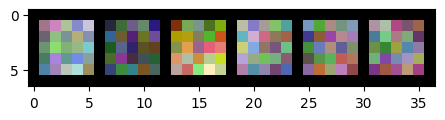

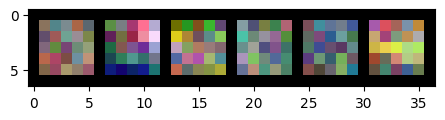

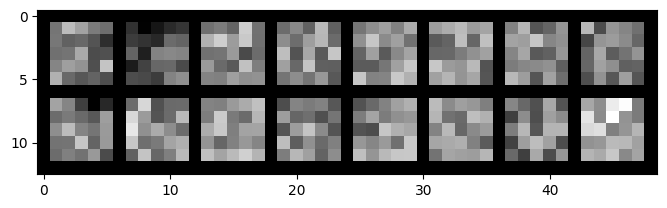

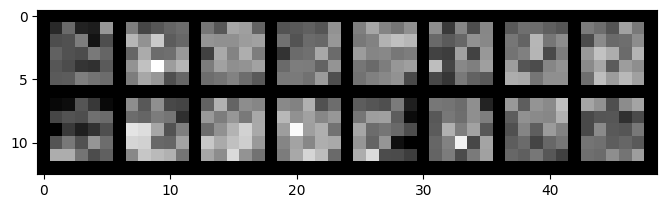

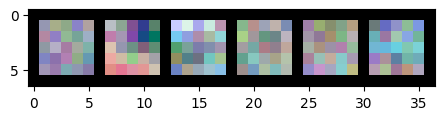

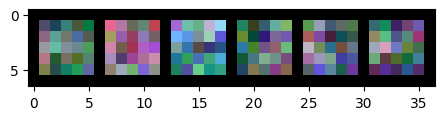

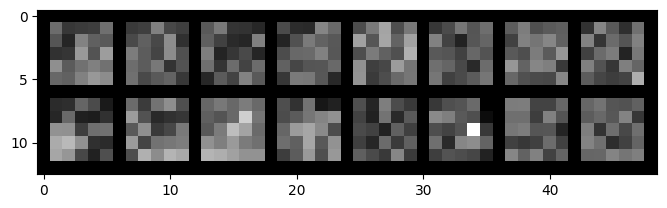

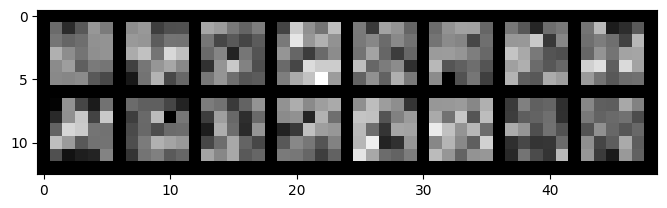

In [990]:

print(fake_A_0.shape)
print(fake_A_2.shape)
visTensor(real_A_0.cpu().permute(1, 0, 2, 3), ch=0, allkernels=False)
visTensor(fake_A_0.cpu(), ch=0, allkernels=False)
visTensor(real_A_2.cpu().permute(1, 0, 2, 3), ch=0, allkernels=False)
visTensor(fake_A_2.cpu(), ch=0, allkernels=False)

print(fake_B_0.shape)
print(fake_B_2.shape)
visTensor(real_B_0.cpu().permute(1, 0, 2, 3), ch=0, allkernels=False)
visTensor(fake_B_0.cpu(), ch=0, allkernels=False)
visTensor(real_B_2.cpu().permute(1, 0, 2, 3), ch=0, allkernels=False)
visTensor(fake_B_2.cpu(), ch=0, allkernels=False)